In [56]:
import batoid
import batoid_rubin
import numpy as np
import matplotlib.pyplot as plt
import yaml
import ipywidgets
from pathlib import Path
from tqdm.notebook import tqdm

from lsst.ts.ofc import OFC, OFCData, StateEstimator, SensitivityMatrix
import lsst.obs.lsst as obs_lsst
from lsst.afw.cameraGeom import FIELD_ANGLE

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
from utils import get_field_angle
sensor_names = ['R00_SW0','R04_SW0','R40_SW0','R44_SW0']

# Get the field angles for the sensors
field_x, field_y = get_field_angle(sensor_names)

print(field_x)
print(field_y)

(1.1256388888888889, 1.1902222222222223, -1.1902222222222223, -1.1256388888888889)
(-1.1902222222222223, 1.1256388888888889, -1.1256388888888889, 1.1902222222222223)


In [57]:
def doubleZernike(
    optic, field, wavelength, rings=7, spokes=25, jmax=22, kmax=22, 
    **kwargs
):

    if spokes is None:
        spokes = 2*rings+1

    Li, w = np.polynomial.legendre.leggauss(rings)
    radii = np.sqrt((1+Li)/2)*field
    w *= np.pi/(2*spokes)
    azs = np.linspace(0, 2*np.pi, spokes, endpoint=False)
    radii, azs = np.meshgrid(radii, azs)
    w = np.broadcast_to(w, radii.shape)
    radii = radii.ravel()
    azs = azs.ravel()
    w = w.ravel()
    thx = radii * np.cos(azs)
    thy = radii * np.sin(azs)
    coefs = []
    for thx_, thy_ in zip(thx, thy):
        coefs.append(batoid.zernike(
            optic, 
            thx_, 
            thy_,
            wavelength,
            jmax=jmax,
            eps=0.61,
            nx=255
        ))
    coefs = np.array(coefs)

    import galsim
    basis = galsim.zernike.zernikeBasis(
        kmax, thx, thy, R_outer=field
    )
    dzs = np.dot(basis, coefs*w[:,None])/np.pi

    return dzs

def evaluate_sensitivity(A, rotation_angle, dofs):
    # Retrieve field angles for each GQ point from ofc_data
    field_x, field_y = zip(*ofc_data.gq_field_angles)

    rotated_sensitivity_matrix = np.array(
        [
            np.array(
                [
                    zk.coef
                    for zk in galsim.zernike.DoubleZernike(
                        A[..., idofidx],
                        # Rubin annuli
                        uv_inner=self.ofc_data.config['pupil']['R_inner'],
                        uv_outer=self.ofc_data.config['pupil']['R_outer'],
                        xy_inner=self.ofc_data.config['obscuration']['R_inner'],
                        xy_outer=self.ofc_data.config['obscuration']['R_outer'],
                    ).rotate(theta_uv=rotation_angle)(field_x, field_y)
                ]
            )
            for idofidx in dofs
        ]
    )

    return rotated_sensitivity_matrix

In [156]:
0.612 * 4.18

2.55816

In [67]:
ofc_data = OFCData('lsst')
fieldx, fieldy = zip(*ofc_data.gq_field_angles)
field_filters = {}

In [157]:


with open(f'/sdf/home/g/gmegias/aos/ts_ofc/policy/sensitivity_matrix/lsst_sensitivity_dz_31_23_50.yaml') as yaml_file:
    double_sen = np.array(yaml.safe_load(yaml_file))


field_sen2 = evaluate_sensitivity(double_sen, 0.0, np.arange(50))
field_sen2 = field_sen2[..., 4:23]
field_sen2 = np.einsum('ijk -> jki', field_sen2)


In [139]:
path = '/sdf/home/g/gmegias/aos/ts_ofc/policy/sensitivity_matrix/legacy/'
with open(path + f"lsst_sensitivity_35_19_50.yaml") as f:
    sen = np.array(yaml.safe_load(f))

filter_name = 'z'
with open(f'/sdf/home/g/gmegias/aos/ts_ofc/policy/sensitivity_matrix/lsst_{filter_name}_sensitivity_dz_31_23_50.yaml') as yaml_file:
    double_sen = np.array(yaml.safe_load(yaml_file))


field_fi = evaluate_sensitivity(double_sen, 0.0, np.arange(50))
field_fi = field_fi[..., 4:23]
field_filters[filter_name] = np.einsum('ijk -> jki', field_fi)

# 35 field points x 19 zernikes x 50 dof

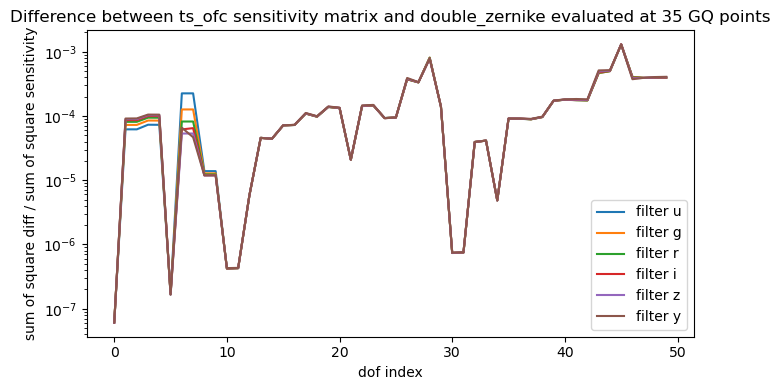

In [140]:
r_dz = []
u_dz = []
y_dz = []
g_dz = []
z_dz = []
i_dz = []

for idof in range(50):
    u_dz.append( np.sum((field_filters['u'][...,idof]-sen[...,idof])**2)/np.sum((sen[...,idof]**2)) )
    g_dz.append( np.sum((field_filters['g'][...,idof]-sen[...,idof])**2)/np.sum((sen[...,idof]**2)) )
    r_dz.append( np.sum((field_sen2[...,idof]-sen[...,idof])**2)/np.sum((sen[...,idof]**2)) )
    y_dz.append( np.sum((field_filters['y'][...,idof]-sen[...,idof])**2)/np.sum((sen[...,idof]**2)) )
    z_dz.append( np.sum((field_filters['z'][...,idof]-sen[...,idof])**2)/np.sum((sen[...,idof]**2)) )
    i_dz.append( np.sum((field_filters['i'][...,idof]-sen[...,idof])**2)/np.sum((sen[...,idof]**2)) )

plt.figure(figsize = (7,4))

plt.semilogy(np.arange(50), u_dz, label='filter u')
plt.semilogy(np.arange(50), g_dz, label='filter g')
plt.semilogy(np.arange(50), r_dz, label='filter r')
plt.semilogy(np.arange(50), i_dz, label='filter i')
plt.semilogy(np.arange(50), z_dz, label='filter z')
plt.semilogy(np.arange(50), y_dz, label='filter y')

plt.xlabel('dof index')
plt.ylabel('sum of square diff / sum of square sensitivity')
plt.legend()


plt.title('Difference between ts_ofc sensitivity matrix and double_zernike evaluated at 35 GQ points')
plt.tight_layout()

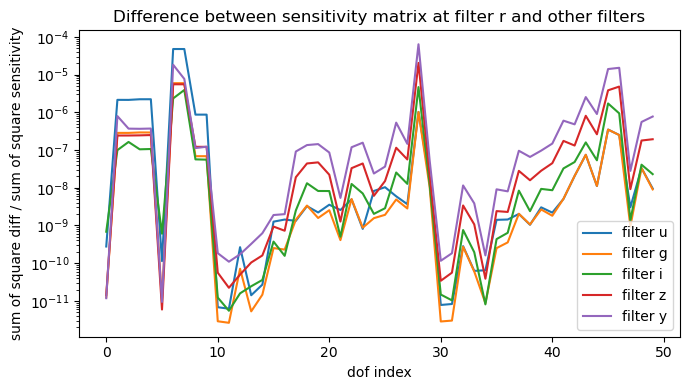

In [141]:

u_dz = []
y_dz = []
g_dz = []
z_dz = []
i_dz = []

for idof in range(50):
    u_dz.append( np.sum((field_filters['u'][...,idof]-field_sen2[...,idof])**2)/np.sum((field_sen2[...,idof]**2)) )
    g_dz.append( np.sum((field_filters['g'][...,idof]-field_sen2[...,idof])**2)/np.sum((field_sen2[...,idof]**2)) )
    y_dz.append( np.sum((field_filters['y'][...,idof]-field_sen2[...,idof])**2)/np.sum((field_sen2[...,idof]**2)) )
    z_dz.append( np.sum((field_filters['z'][...,idof]-field_sen2[...,idof])**2)/np.sum((field_sen2[...,idof]**2)) )
    i_dz.append( np.sum((field_filters['i'][...,idof]-field_sen2[...,idof])**2)/np.sum((field_sen2[...,idof]**2)) )

plt.figure(figsize = (7,4))

plt.semilogy(np.arange(50), u_dz, label='filter u')
plt.semilogy(np.arange(50), g_dz, label='filter g')
plt.semilogy(np.arange(50), i_dz, label='filter i')
plt.semilogy(np.arange(50), z_dz, label='filter z')
plt.semilogy(np.arange(50), y_dz, label='filter y')

plt.xlabel('dof index')
plt.ylabel('sum of square diff / sum of square sensitivity')
plt.legend()


plt.title('Difference between sensitivity matrix at filter r and other filters')
plt.tight_layout()